# Process
?

In [100]:
import sys
import os
import numpy as np
import pandas as pd
import math
from scipy import stats
import sklearn.metrics as sklm
import sklearn.model_selection as ms
from sklearn import preprocessing
import joblib
import json
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    KFold,
    cross_val_score,
    cross_val_predict,
)
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import xgboost as xgb
import colorlover as cl

#SHapley Additive exPlanations (SHAP)
import shap

# configs
pd.options.display.float_format = "{:,.2f}".format
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 6
pio.templates.default = "plotly_white"

In [104]:
sys.path.append("../")
from cnrdlib import cl_ml as clml

In [105]:
df = pd.read_csv("../data/daily_data.csv.gz", compression="gzip", parse_dates=True, index_col="timestamp")
df.head()

,CDD_calc,WIP_energy,DP_energy,WIP_temp,DP_temp,Ext_temp,DP_setpoint
timestamp,,,,,,,
2021-03-30,15.32,110.54,71.60,4.43,3.40,19.32,low
2021-03-31,19.23,168.87,65.99,6.68,5.37,23.23,high
2021-04-01,20.87,217.91,79.20,6.81,5.01,24.87,high
2021-04-02,18.14,180.26,67.72,4.66,3.03,22.14,low
2021-04-03,16.73,81.34,65.36,5.87,2.94,20.73,low


In [106]:
df["day_of_week"] = df.index.dayofweek
df.head()

,CDD_calc,WIP_energy,DP_energy,WIP_temp,DP_temp,Ext_temp,DP_setpoint,day_of_week
timestamp,,,,,,,,
2021-03-30,15.32,110.54,71.60,4.43,3.40,19.32,low,1
2021-03-31,19.23,168.87,65.99,6.68,5.37,23.23,high,2
2021-04-01,20.87,217.91,79.20,6.81,5.01,24.87,high,3
2021-04-02,18.14,180.26,67.72,4.66,3.03,22.14,low,4
2021-04-03,16.73,81.34,65.36,5.87,2.94,20.73,low,5


In [107]:
len(df[df.DP_setpoint == "high"])

53

In [108]:
len(df[df.DP_setpoint == "low"])

61

In [109]:
df_bl = df[df.DP_setpoint == "high"]
df_rp = df[df.DP_setpoint == "low"]

In [111]:
# feat_cols = ["DP_temp", "Ext_temp", "CDD_calc"]
feat_cols = ["DP_temp", "Ext_temp"]
print(feat_cols)

feat_labs_cols = feat_cols + ["DP_energy"]
print(feat_labs_cols)

['DP_temp', 'Ext_temp']
['DP_temp', 'Ext_temp', 'DP_energy']


In [112]:
# split features into numpy array
features = np.array(df_bl[feat_cols])
print(features.shape)

(53, 2)


In [113]:
p = features.shape[1]
print(p)

2


In [114]:
label = np.array(df_bl["DP_energy"])

In [115]:
# train-test split
np.random.seed(9988)

indx = range(features.shape[0])
indx = ms.train_test_split(
    indx,
    test_size=0.30,
)

x_train = features[indx[0], :]
y_train = np.ravel(label[indx[0]])
x_test = features[indx[1], :]
y_test = np.ravel(label[indx[1]])

In [116]:
# scale features
scaler = preprocessing.StandardScaler().fit(x_train[:, :])
x_train[:, :] = scaler.transform(x_train[:, :])
x_test[:, :] = scaler.transform(x_test[:, :])

# save scaler model
joblib.dump(scaler, "../models/model_feature_scaling.pkl")

x_train[:5, :]

array([[ 0.06880035, -0.74076585],
       [-0.32940715, -1.36334139],
       [ 0.05412694,  1.02264725],
       [-2.40242856,  0.18821673],
       [ 0.22056822,  0.52430432]])

# Linear model
Base reference

In [117]:
x_train_constant = sm.add_constant(x_train)
x_test_constant = sm.add_constant(x_test)

In [118]:
model_lin = sm.OLS(y_train, x_train_constant)
model_lin_fit = model_lin.fit()
model_lin_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     28.81
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           4.79e-08
Time:                        22:22:47   Log-Likelihood:                -113.21
No. Observations:                  37   AIC:                             232.4
Df Residuals:                      34   BIC:                             237.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.3381      0.885     59.144      0.000      50.540      54.136
x1            -0.8175      0.889     -0.919      0.364      -2.625       0.990
x2             6.5878      0.889      7.408      0.000       4.781       8.395
==============================================================================
Omnibus:                       16.039   Durbin-Watson:                   2.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.884
Skew:                           1.195   Prob(JB):                     1.77e-05
Kurtosis:                       5.913   Cond. No.                         1.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
y_hat = model_lin_fit.predict(x_train_constant)

In [120]:
clml.regression_metrics(y_train, y_hat, p)

Root Mean Square Error = 5.16
Mean Absolute Error    = 3.43
Median Absolute Error  = 1.70
R^2                    = 0.6289
Adjusted R^2           = 0.6183


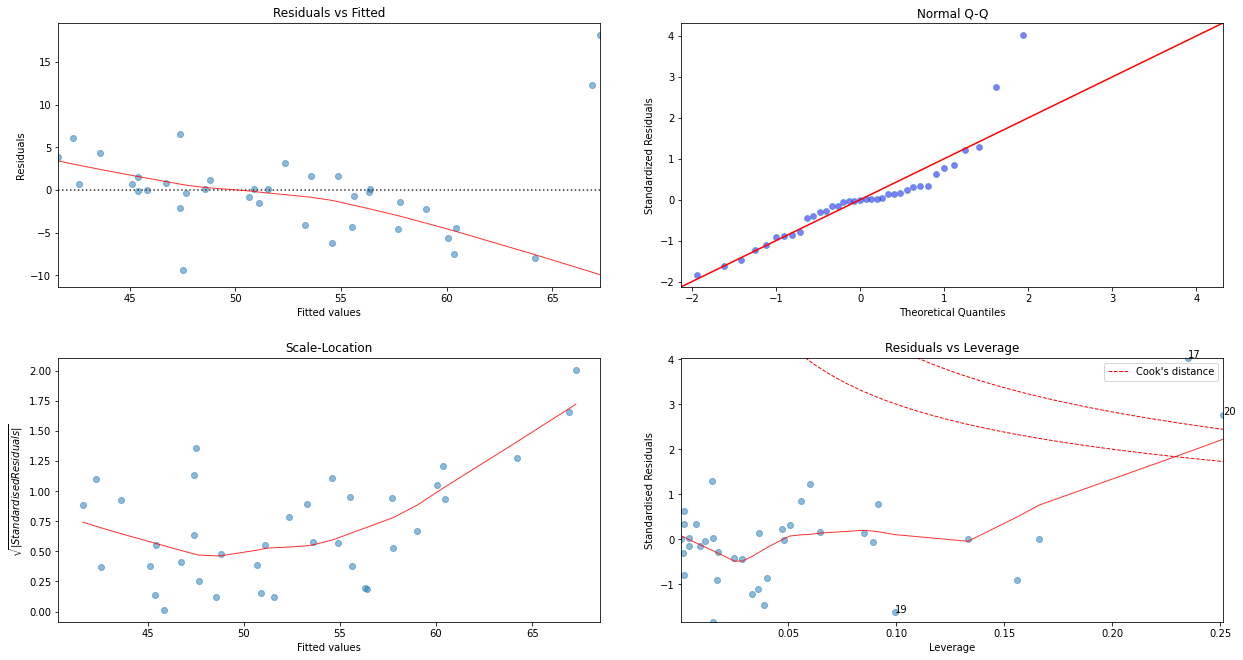

In [121]:
clml.diagnostic_plots(x_train, y_train, y_hat)

In [122]:
y_score = model_lin_fit.predict(x_test_constant)
clml.regression_metrics(y_test, y_score, p)

Root Mean Square Error = 6.07
Mean Absolute Error    = 4.74
Median Absolute Error  = 3.54
R^2                    = 0.5585
Adjusted R^2           = 0.5270


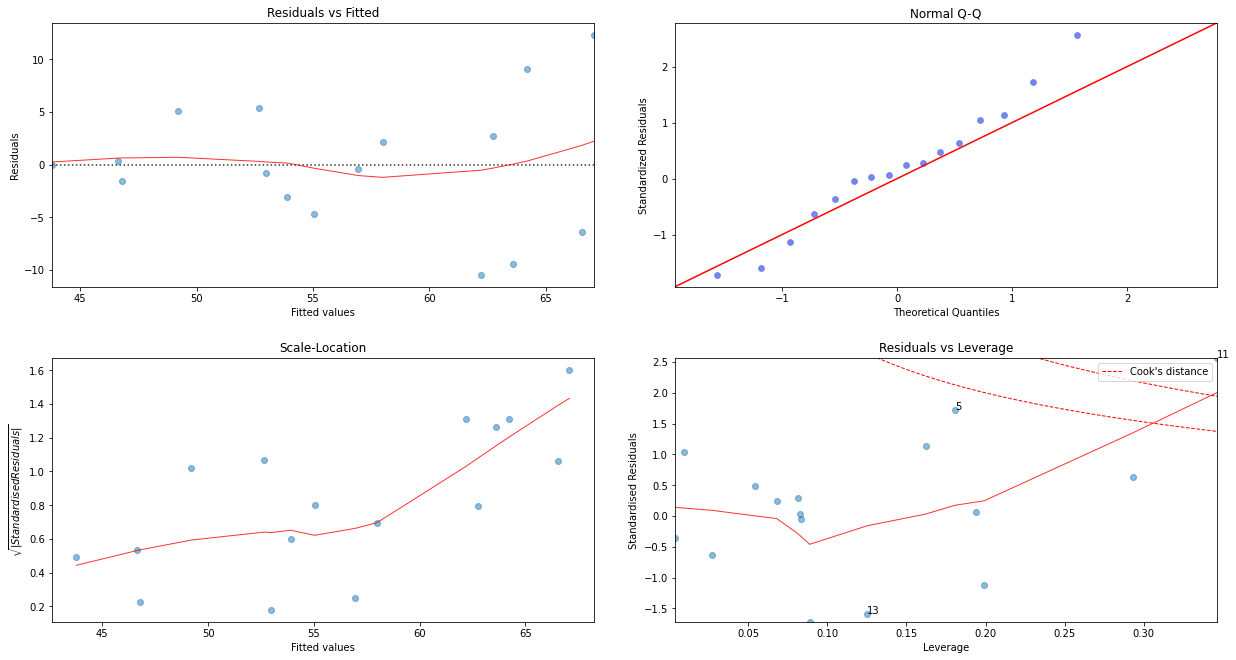

In [123]:
clml.diagnostic_plots(x_test, y_test, y_score)

# XGBoost

In [124]:
# set up parameter grid
xgbm_param_grid = {
    "learning_rate": [0.01, 0.1, 0.3, 0.6, 0.9],
    "n_estimators": [25, 50, 100, 150],
    "subsample": [0.3, 0.5, 0.9],
    "colsample_bytree": [0.3, 0.5, 0.7],
    "gamma": [0.3, 0.5, 0.7],
    "max_depth": [3, 5, 7, 9],
    "objective": ["reg:squarederror"],
}

In [125]:
k_fold = KFold(n_splits=3)
model_xgb = xgb.XGBRegressor()

In [126]:
grid_mse = GridSearchCV(
    estimator=model_xgb,
    param_grid=xgbm_param_grid,
    scoring="neg_mean_squared_error",
    cv=k_fold,
    verbose=1,
    n_jobs=8,
)

In [127]:
grid_mse.fit(x_train, y_train)

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, mo...
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_jobs=8,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'gamma': [

In [128]:
# print the best parameters and lowest RMSE
print(f"Best parameters found: {grid_mse.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(grid_mse.best_score_)):0.2f}")

Best parameters found: {'colsample_bytree': 0.3, 'gamma': 0.3, 'learning_rate': 0.6, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'subsample': 0.3}
Lowest RMSE found: 8.06


In [129]:
# use best parameters
model_xgb = xgb.XGBRegressor(
    colsample_bytree=0.3,
    gamma=0.3,
    learning_rate=0.6,
    max_depth=3,
    n_estimators=100,
    subsample=0.3,
)

In [130]:
# fit model
model_xgb_fit = model_xgb.fit(x_train, y_train)

In [131]:
y_hat = model_xgb_fit.predict(x_train)
clml.regression_metrics(y_train, y_hat, p)

Root Mean Square Error = 0.82
Mean Absolute Error    = 0.53
Median Absolute Error  = 0.34
R^2                    = 0.9907
Adjusted R^2           = 0.9904


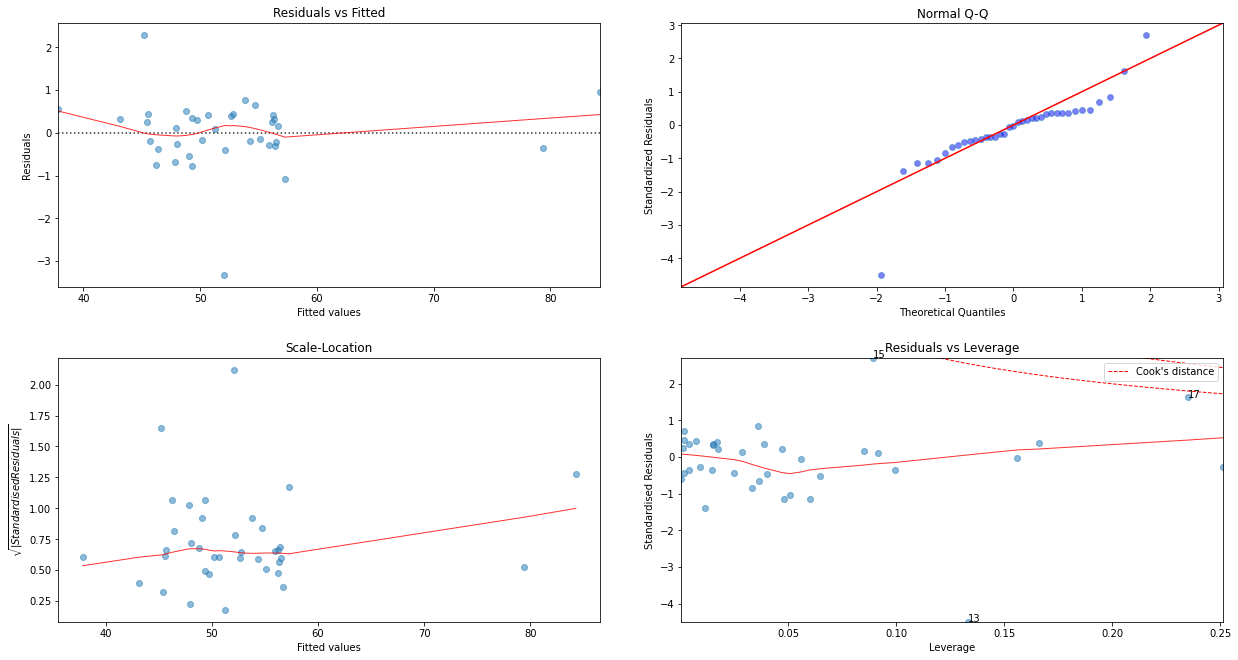

In [132]:
clml.diagnostic_plots(x_train, y_train, y_hat)

In [133]:
y_score = model_xgb_fit.predict(x_test)
clml.regression_metrics(y_test, y_score, p)

Root Mean Square Error = 7.21
Mean Absolute Error    = 5.86
Median Absolute Error  = 4.73
R^2                    = 0.3766
Adjusted R^2           = 0.3320


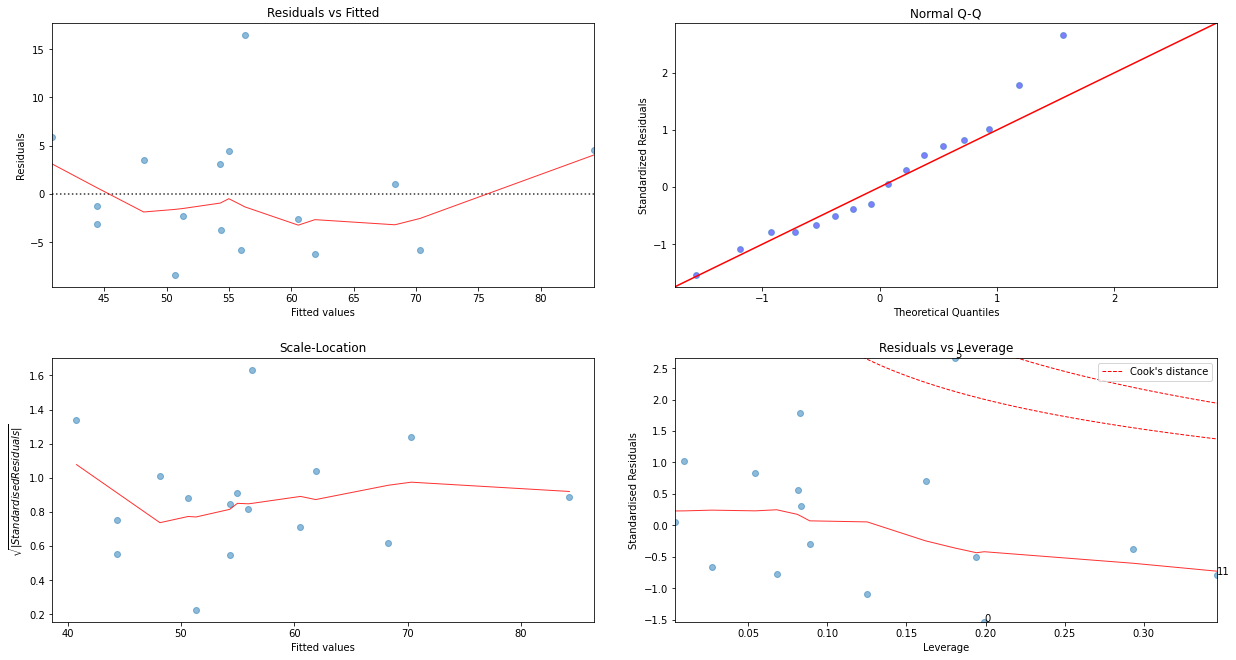

In [134]:
clml.diagnostic_plots(x_test, y_test, y_score)

In [135]:
#explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model_xgb_fit)
shap_values = explainer.shap_values(x_train)

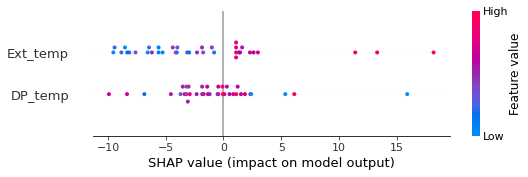

In [136]:
#summarize the effects of all the features
shap.summary_plot(shap_values, x_train, feature_names=feat_cols)

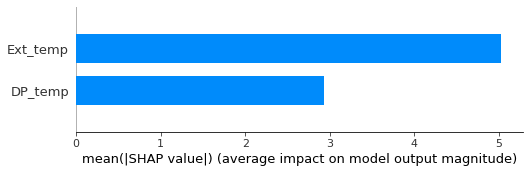

In [137]:
shap.summary_plot(shap_values, x_train, plot_type='bar', feature_names=feat_cols)

In [138]:
# save model model
joblib.dump(model_xgb_fit, "../models/model_predict_xgboost.pkl")

['../models/model_predict_xgboost.pkl']

In [139]:
SEmodel = math.sqrt(sklm.mean_squared_error(y_test, y_score))
print(f"Standard error of the model is {SEmodel:0.2f}")

Standard error of the model is 7.21


In [140]:
## Calculate energy performance using the baseline model

In [141]:
# split features into numpy array
features_rp = np.array(df_rp[feat_cols])
print(features_rp.shape)

(61, 2)


In [142]:
# import models for reporting period
scaler = joblib.load("../models/model_feature_scaling.pkl")
model_opt = joblib.load("../models/model_predict_xgboost.pkl")

In [143]:
x_rp = scaler.transform(features_rp[:, :])
x_rp[:5, :]

array([[-3.00642001,  0.7022593 ],
       [-4.07207238,  1.56866186],
       [-4.32860558,  1.13529274],
       [-4.40603744,  0.77872518],
       [-4.62782771,  0.97243353]])

In [144]:
# predict expected consumption
y_rp = model_opt.predict(x_rp)

In [145]:
df_rp["ExpectedkWh"] = y_rp

df_rp["Residuals"] = df_rp.DP_energy - df_rp.ExpectedkWh
df_rp["CUSUM"] = df_rp.Residuals.cumsum()

df_rp["TargetkWh"] = df_rp.ExpectedkWh * 0.97
df_rp["ResidualsT"] = df_rp.TargetkWh - df_rp.ExpectedkWh
df_rp["CUSUMT"] = df_rp.ResidualsT.cumsum()

print(
    "Cumulative performance against actual: {0:,.0f} kWh".format(
        df_rp["CUSUM"].tail(1).values[0]
    )
)

Cumulative performance against actual: 203 kWh


In [151]:
traceE = go.Scatter(
    x=df_rp.index, y=df_rp.CUSUM, name="Cumulative energy performance [kWh]"
)

layout = go.Layout(
    legend=dict(orientation="h"),
    title="Cumulative energy performance",
    xaxis=dict(
        title="",
        titlefont=dict(
            # size=18,
            color="#7f7f7f"
        ),
    ),
    yaxis=dict(
        title="Cumulative energy [kWh]",
        titlefont=dict(
            # size=18,
            color="#7f7f7f"
        ),
    ),
)
data = [traceE]
fig = go.Figure(data=data, layout=layout)
fig.show()

In [152]:
no_of_days = len(df_rp.index)
additional_energy = df_rp["CUSUM"].tail(1).values[0]
additional_energy_per_day = additional_energy / no_of_days
print(additional_energy_per_day)

3.319988632354209


In [153]:
print(f"Additional energy is {additional_energy_per_day:0.2f} kWh per day")
print(f"Over a year, that equates to {additional_energy_per_day*365:0.0f} kWh per annum")
print(f"That is approximately a reduction of {additional_energy_per_day*365*1.04:0.0f} kg CO2e and saving R {additional_energy_per_day*365*1.80:0.0f} per annum")

Additional energy is 3.32 kWh per day
Over a year, that equates to 1212 kWh per annum
That is approximately a reduction of 1260 kg CO2e and saving R 2181 per annum
